In [1]:

from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/ECE253/')
import os
path="/content/drive/My Drive/Colab Notebooks/ECE253/"
os.chdir(path)
os.listdir(path)
%cd ./MPRNet-main/
%cd pytorch-gradual-warmup-lr
!python setup.py install
%cd ..
%ls
%cd ./Deblurring/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/ECE253/MPRNet-main
/content/drive/My Drive/Colab Notebooks/ECE253/MPRNet-main/pytorch-gradual-warmup-lr
running install
/usr/local/lib/python3.12/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.12/dist-packages/setuptools/_distutils/cmd.py:66: EasyInstallDeprecationWarning: easy_install command is de

In [2]:
#!conda create -n pytorch1 python=3.7
#!conda activate pytorch1
#!conda install pytorch=1.1 torchvision=0.3 cudatoolkit=9.0 -c pytorch
!pip install matplotlib scikit-image opencv-python yacs joblib natsort h5py tqdm utils
!pip install warmup-scheduler
!pip install lpips

DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/warmup_scheduler-0.3-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13906 sha256=4765601e8e3e55c1f5ad7de2294da06e83c35ef4293f799bfdc9eed2d04ce1ae
  Stored in directory: /root/.cache/pip/wheels/b6/a1/81/1036477786ae0e17b522f6f5a838f9bc4288d1016fc5d0e1ec
Successfully built utils
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/warmup_scheduler-0.3-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/warmup_scheduler-0.3-py3.

In [22]:
#!python train_colab.py
import os
import random
import time
import numpy as np
import shutil

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from config import Config
import utils
from data_RGB import get_training_data, get_validation_data
from MPRNet import MPRNet
import losses
from tqdm import tqdm

# =======================
# 0. Device & Seed
# =======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

random.seed(1234)
np.random.seed(1234)
torch.manual_seed(1234)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(1234)
    torch.backends.cudnn.benchmark = True

# =======================
# 1. Load training settings
# =======================
opt = Config('training.yml')

# Local hyper-parameters for Colab
# You can freely change these three in this cell
LOCAL_BATCH_SIZE   = 8    # batch size for training
TRAIN_PS           = 128  # training patch size
VAL_PS             = 128  # validation patch size
LOCAL_NUM_EPOCHS   = 20   # number of epochs to run

start_epoch = 1
mode    = opt.MODEL.MODE
session = opt.MODEL.SESSION

result_dir = os.path.join(opt.TRAINING.SAVE_DIR, mode, 'results', session)
model_dir  = os.path.join(opt.TRAINING.SAVE_DIR, mode, 'models',  session)

utils.mkdir(result_dir)
utils.mkdir(model_dir)

train_dir = opt.TRAINING.TRAIN_DIR
val_dir   = opt.TRAINING.VAL_DIR

print("Train dir:", train_dir)
print("Val dir  :", val_dir)
print("Batch size (local):", LOCAL_BATCH_SIZE)
print("Train patch size (local):", TRAIN_PS)
print("Val patch size (local):", VAL_PS)
print("Num epochs in this run:", LOCAL_NUM_EPOCHS)

# =======================
# 2. Build model and optimizer
# =======================
model_restoration = MPRNet().to(device)

# Keep it single-GPU and memory-friendly
num_params = sum(p.numel() for p in model_restoration.parameters()) / 1e6
print(f"Model parameters: {num_params:.2f} M")

new_lr = opt.OPTIM.LR_INITIAL
optimizer = optim.Adam(
    model_restoration.parameters(),
    lr=new_lr,
    betas=(0.9, 0.999),
    eps=1e-8
)

# =======================
# 3. (Optional) Load pretrained weights
# =======================
pretrained_path = './pretrained_models/model_deblurring.pth'
if os.path.exists(pretrained_path):
    checkpoint = torch.load(pretrained_path, map_location=device)
    # Some checkpoints store the model under 'state_dict', some directly
    if isinstance(checkpoint, dict) and 'state_dict' in checkpoint:
        model_restoration.load_state_dict(checkpoint['state_dict'])
    else:
        model_restoration.load_state_dict(checkpoint)
    print(f"Loaded pretrained weights from: {pretrained_path}")
else:
    print(f"[Warn] Pretrained weights NOT found at {pretrained_path}, training from scratch.")

# =======================
# 4. Scheduler (simple cosine, no warmup)
# =======================
# Use LOCAL_NUM_EPOCHS here so the schedule matches the number of epochs in this run
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=LOCAL_NUM_EPOCHS,
    eta_min=opt.OPTIM.LR_MIN
)

# =======================
# 5. (Optional) Resume from latest checkpoint
# =======================
if opt.TRAINING.RESUME:
    path_chk_rest = utils.get_last_path(model_dir, '_latest.pth')
    utils.load_checkpoint(model_restoration, path_chk_rest)
    start_epoch = utils.load_start_epoch(path_chk_rest) + 1
    utils.load_optim(optimizer, path_chk_rest)

    # Step the scheduler up to the resumed epoch
    for _ in range(1, start_epoch):
        scheduler.step()
    new_lr = scheduler.get_last_lr()[0]
    print('------------------------------------------------------------------------------')
    print("==> Resuming training with learning rate:", new_lr)
    print('------------------------------------------------------------------------------')

# =======================
# 6. Loss functions
# =======================
criterion_char = losses.CharbonnierLoss().to(device)
criterion_edge = losses.EdgeLoss().to(device)

# =======================
# 7. Datasets and Dataloaders
# =======================
train_dataset = get_training_data(train_dir, {'patch_size': TRAIN_PS})
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=LOCAL_BATCH_SIZE,
    shuffle=True,
    num_workers=2,       # small is safer in Colab
    drop_last=False,
    pin_memory=True
)

val_dataset = get_validation_data(val_dir, {'patch_size': VAL_PS})
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=1,        # no need for large batch in validation
    shuffle=False,
    num_workers=2,
    drop_last=False,
    pin_memory=True
)

end_epoch = start_epoch + LOCAL_NUM_EPOCHS - 1
print('===> Start Epoch {} End Epoch {}'.format(start_epoch, end_epoch))
print('===> Loading datasets done.')

best_psnr  = 0.0
best_epoch = 0

# =======================
# 8. Training loop
# =======================
for epoch in range(start_epoch, end_epoch + 1):
    epoch_start_time = time.time()
    epoch_loss = 0.0

    model_restoration.train()
    for i, data in enumerate(tqdm(train_loader), 0):

        # Manually clear gradients (slightly more efficient than optimizer.zero_grad())
        for param in model_restoration.parameters():
            param.grad = None

        # data_RGB usually returns [target, input]
        target = data[0].to(device)
        input_ = data[1].to(device)

        restored = model_restoration(input_)  # list of stage outputs

        # Compute loss across all stages
        loss_char = torch.sum(torch.stack(
            [criterion_char(restored[j], target) for j in range(len(restored))]
        ))
        loss_edge = torch.sum(torch.stack(
            [criterion_edge(restored[j], target) for j in range(len(restored))]
        ))
        loss = loss_char + 0.05 * loss_edge

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # ====== Validation ======
    if epoch % opt.TRAINING.VAL_AFTER_EVERY == 0:
        model_restoration.eval()
        psnr_val_rgb = []
        with torch.no_grad():
            for ii, data_val in enumerate(val_loader, 0):
                target = data_val[0].to(device)
                input_ = data_val[1].to(device)

                restored = model_restoration(input_)
                restored = restored[0]  # take the first stage output

                for res, tar in zip(restored, target):
                    psnr_val_rgb.append(utils.torchPSNR(res, tar))

        psnr_val_rgb = torch.stack(psnr_val_rgb).mean().item()

        if psnr_val_rgb > best_psnr:
            best_psnr  = psnr_val_rgb
            best_epoch = epoch
            torch.save(
                {
                    'epoch': epoch,
                    'state_dict': model_restoration.state_dict(),
                    'optimizer': optimizer.state_dict()
                },
                os.path.join(model_dir, "model_best.pth")
            )

        print("[epoch %d PSNR: %.4f --- best_epoch %d Best_PSNR %.4f]" %
              (epoch, psnr_val_rgb, best_epoch, best_psnr))

        torch.save(
            {
                'epoch': epoch,
                'state_dict': model_restoration.state_dict(),
                'optimizer': optimizer.state_dict()
            },
            os.path.join(model_dir, f"model_epoch_{epoch}.pth")
        )

    # ====== Scheduler & Logging ======
    scheduler.step()
    cur_lr = scheduler.get_last_lr()[0]
    print("------------------------------------------------------------------")
    print("Epoch: {}\tTime: {:.2f}s\tLoss: {:.4f}\tLearningRate {:.6f}".format(
        epoch, time.time() - epoch_start_time, epoch_loss, cur_lr))
    print("------------------------------------------------------------------")

    # Save latest checkpoint
    torch.save(
        {
            'epoch': epoch,
            'state_dict': model_restoration.state_dict(),
            'optimizer': optimizer.state_dict()
        },
        os.path.join(model_dir, "model_latest.pth")
    )

# =======================
# 9. Export best model to pretrained_models
# =======================
best_model_src = os.path.join(model_dir, "model_best.pth")
export_dir = "./pretrained_models"
os.makedirs(export_dir, exist_ok=True)

base_name = "model_withRealBlur"
ext = ".pth"
export_path = os.path.join(export_dir, base_name + ext)

# If the target file exists, append an index: model_withRealBlur_1.pth, _2.pth, ...
if os.path.exists(export_path):
    idx = 1
    while True:
        candidate = os.path.join(export_dir, f"{base_name}_{idx}{ext}")
        if not os.path.exists(candidate):
            export_path = candidate
            break
        idx += 1

if os.path.exists(best_model_src):
    shutil.copy2(best_model_src, export_path)
    print(f"Best model copied from {best_model_src} to {export_path}")
else:
    print(f"[Warn] Best model {best_model_src} not found. Nothing was copied.")

Using device: cuda
Train dir: ./Datasets/RealBlur/train
Val dir  : ./Datasets/RealBlur/test
Batch size (local): 8
Train patch size (local): 128
Val patch size (local): 128
Num epochs in this run: 20
Model parameters: 20.13 M
Loaded pretrained weights from: ./pretrained_models/model_deblurring.pth
===> Start Epoch 1 End Epoch 20
===> Loading datasets done.


100%|██████████| 5/5 [00:34<00:00,  6.82s/it]


------------------------------------------------------------------
Epoch: 1	Time: 34.09s	Loss: 0.1038	LearningRate 0.000199
------------------------------------------------------------------


100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


------------------------------------------------------------------
Epoch: 2	Time: 5.75s	Loss: 0.0915	LearningRate 0.000195
------------------------------------------------------------------


100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


------------------------------------------------------------------
Epoch: 3	Time: 5.80s	Loss: 0.0850	LearningRate 0.000189
------------------------------------------------------------------


100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


------------------------------------------------------------------
Epoch: 4	Time: 5.19s	Loss: 0.1042	LearningRate 0.000181
------------------------------------------------------------------


100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


------------------------------------------------------------------
Epoch: 5	Time: 5.18s	Loss: 0.0805	LearningRate 0.000171
------------------------------------------------------------------


100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


------------------------------------------------------------------
Epoch: 6	Time: 5.19s	Loss: 0.0871	LearningRate 0.000159
------------------------------------------------------------------


100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


------------------------------------------------------------------
Epoch: 7	Time: 5.77s	Loss: 0.0802	LearningRate 0.000146
------------------------------------------------------------------


100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


------------------------------------------------------------------
Epoch: 8	Time: 5.82s	Loss: 0.0875	LearningRate 0.000131
------------------------------------------------------------------


100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


------------------------------------------------------------------
Epoch: 9	Time: 5.20s	Loss: 0.0786	LearningRate 0.000116
------------------------------------------------------------------


100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


------------------------------------------------------------------
Epoch: 10	Time: 5.17s	Loss: 0.0780	LearningRate 0.000101
------------------------------------------------------------------


100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


------------------------------------------------------------------
Epoch: 11	Time: 5.17s	Loss: 0.0661	LearningRate 0.000085
------------------------------------------------------------------


100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


------------------------------------------------------------------
Epoch: 12	Time: 5.77s	Loss: 0.0854	LearningRate 0.000070
------------------------------------------------------------------


100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


------------------------------------------------------------------
Epoch: 13	Time: 5.73s	Loss: 0.0739	LearningRate 0.000055
------------------------------------------------------------------


100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


------------------------------------------------------------------
Epoch: 14	Time: 5.19s	Loss: 0.0854	LearningRate 0.000042
------------------------------------------------------------------


100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


------------------------------------------------------------------
Epoch: 15	Time: 5.15s	Loss: 0.0830	LearningRate 0.000030
------------------------------------------------------------------


100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


------------------------------------------------------------------
Epoch: 16	Time: 5.14s	Loss: 0.0825	LearningRate 0.000020
------------------------------------------------------------------


100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


------------------------------------------------------------------
Epoch: 17	Time: 5.13s	Loss: 0.0841	LearningRate 0.000012
------------------------------------------------------------------


100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


------------------------------------------------------------------
Epoch: 18	Time: 5.74s	Loss: 0.0701	LearningRate 0.000006
------------------------------------------------------------------


100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


------------------------------------------------------------------
Epoch: 19	Time: 5.13s	Loss: 0.0757	LearningRate 0.000002
------------------------------------------------------------------


100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


[epoch 20 PSNR: 29.3923 --- best_epoch 20 Best_PSNR 29.3923]
------------------------------------------------------------------
Epoch: 20	Time: 39.77s	Loss: 0.0805	LearningRate 0.000001
------------------------------------------------------------------
Best model copied from ./checkpoints/Deblurring/models/MPRNet/model_best.pth to ./pretrained_models/model_withRealBlur.pth


In [25]:
### Test with non-retrained model
import os
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from skimage import img_as_ubyte, img_as_float
from skimage import io
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

import lpips  # make sure you've run: !pip install lpips
import utils
from data_RGB import get_test_data
from MPRNet import MPRNet

# =========================
# 1. Set arguments manually
# =========================
class Args:
    pass

args = Args()
args.input_dir  = './Datasets/'                          # dataset root
args.result_dir = './results/without_retrain'                           # where to save outputs
args.weights    = './pretrained_models/model_deblurring.pth'
# args.dataset    = 'GoPro'
args.dataset    = 'RealBlur'                             # change to 'GoPro' if needed

print("Input dir :", args.input_dir)
print("Result dir:", args.result_dir)
print("Weights   :", args.weights)
print("Dataset   :", args.dataset)

# =========================
# 2. Device and model
# =========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model_restoration = MPRNet().to(device)

# Load checkpoint
checkpoint = torch.load(args.weights, map_location=device)
if isinstance(checkpoint, dict) and 'state_dict' in checkpoint:
    model_restoration.load_state_dict(checkpoint['state_dict'])
else:
    model_restoration.load_state_dict(checkpoint)
print("===> Testing using weights:", args.weights)

model_restoration.eval()

# =========================
# 3. Dataloader
# =========================
dataset_name = args.dataset
rgb_dir_test = os.path.join(args.input_dir, dataset_name, 'test', 'input')
print("Test input dir:", rgb_dir_test)

test_dataset = get_test_data(rgb_dir_test, img_options={})
test_loader  = DataLoader(
    dataset=test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=2,
    drop_last=False,
    pin_memory=True
)

# =========================
# 4. Result directory
# =========================
result_dir = os.path.join(args.result_dir, dataset_name)
utils.mkdir(result_dir)
print("Saving results to:", result_dir)

# =========================
# 5. Prepare GT and metrics (PSNR / SSIM / LPIPS)
# =========================
gt_dir = os.path.join(args.input_dir, dataset_name, 'test', 'target')
compute_metrics = os.path.isdir(gt_dir)

psnr_list  = []
ssim_list  = []
lpips_list = []

if compute_metrics:
    print("Ground-truth dir found, will compute PSNR / SSIM / LPIPS:", gt_dir)
    lpips_model = lpips.LPIPS(net='alex').to(device)
    lpips_model.eval()
else:
    print("Ground-truth dir NOT found, will NOT compute PSNR / SSIM / LPIPS.")

# helper: find GT image path with various possible extensions
def find_gt_path(base_name, gt_root):
    for ext in ['.png', '.jpg', '.jpeg', '.bmp']:
        cand = os.path.join(gt_root, base_name + ext)
        if os.path.exists(cand):
            return cand
    return None

# =========================
# 6. Inference loop
# =========================
with torch.no_grad():
    for ii, data_test in enumerate(tqdm(test_loader), 0):
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        input_    = data_test[0].to(device)
        filenames = data_test[1]  # list of base names (without extension)

        # --- pad to multiple of 8 ---
        factor = 8
        h, w = input_.shape[2], input_.shape[3]
        H = ((h + factor - 1) // factor) * factor
        W = ((w + factor - 1) // factor) * factor
        padh = H - h
        padw = W - w
        if padh != 0 or padw != 0:
            input_ = F.pad(input_, (0, padw, 0, padh), mode='reflect')

        # Forward pass
        restored = model_restoration(input_)
        restored = torch.clamp(restored[0], 0, 1)

        # --- unpad back to original size ---
        if padh != 0 or padw != 0:
            restored = restored[:, :, :h, :w]

        # restored: [1, 3, H, W]
        restored_np = restored.permute(0, 2, 3, 1).cpu().detach().numpy()  # [1, H, W, 3]

        for b in range(len(restored_np)):
            base_name = filenames[b]
            out_img   = restored_np[b]        # float [0,1], HxWx3
            out_u8    = img_as_ubyte(out_img)

            # save restored image
            save_path = os.path.join(result_dir, base_name + '.png')
            utils.save_img(save_path, out_u8)

            # ---------- compute metrics if GT exists ----------
            if compute_metrics:
                gt_path = find_gt_path(base_name, gt_dir)
                if gt_path is None:
                    # no matching GT file, skip metrics for this image
                    continue

                gt_img = io.imread(gt_path)
                gt_f   = img_as_float(gt_img)

                # ensure 3 channels
                if gt_f.ndim == 2:
                    gt_f = np.stack([gt_f, gt_f, gt_f], axis=-1)
                if out_img.ndim == 2:
                    out_img = np.stack([out_img, out_img, out_img], axis=-1)

                # resize / crop if shapes mismatch (ideally they should be identical)
                if gt_f.shape != out_img.shape:
                    Hmin = min(gt_f.shape[0], out_img.shape[0])
                    Wmin = min(gt_f.shape[1], out_img.shape[1])
                    gt_f    = gt_f[:Hmin, :Wmin, :]
                    out_img = out_img[:Hmin, :Wmin, :]

                # PSNR
                psnr_val = peak_signal_noise_ratio(gt_f, out_img, data_range=1.0)
                psnr_list.append(psnr_val)

                # SSIM
                ssim_val = structural_similarity(
                    gt_f,
                    out_img,
                    data_range=1.0,
                    channel_axis=-1  # for skimage >= 0.19
                )
                ssim_list.append(ssim_val)

                # LPIPS: CHW tensor in [-1, 1], float32
                gt_t  = torch.from_numpy(gt_f).permute(2, 0, 1).unsqueeze(0).to(device=device, dtype=torch.float32)
                out_t = torch.from_numpy(out_img).permute(2, 0, 1).unsqueeze(0).to(device=device, dtype=torch.float32)
                gt_t  = gt_t * 2.0 - 1.0
                out_t = out_t * 2.0 - 1.0

                lpips_val = lpips_model(gt_t, out_t).item()
                lpips_list.append(lpips_val)

# =========================
# 7. Print metric summary
# =========================
if compute_metrics and len(psnr_list) > 0:
    mean_psnr  = np.mean(psnr_list)
    mean_ssim  = np.mean(ssim_list)
    mean_lpips = np.mean(lpips_list)
    print("========================================")
    print(f"Average PSNR  : {mean_psnr:.4f} dB")
    print(f"Average SSIM  : {mean_ssim:.4f}")
    print(f"Average LPIPS : {mean_lpips:.4f}")
    print("========================================")
else:
    print("No metrics computed (either GT not found or list is empty).")

print("Done! Deblurred images are saved in:", result_dir)

Input dir : ./Datasets/
Result dir: ./results/without_retrain
Weights   : ./pretrained_models/model_deblurring.pth
Dataset   : RealBlur
Using device: cuda
===> Testing using weights: ./pretrained_models/model_deblurring.pth
Test input dir: ./Datasets/RealBlur/test/input
Saving results to: ./results/without_retrain/RealBlur
Ground-truth dir found, will compute PSNR / SSIM / LPIPS: ./Datasets/RealBlur/test/target
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth


100%|██████████| 40/40 [00:54<00:00,  1.37s/it]

Average PSNR  : 29.4232 dB
Average SSIM  : 0.9160
Average LPIPS : 0.0918
Done! Deblurred images are saved in: ./results/without_retrain/RealBlur


In [23]:
### Test with retrained model
import os
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from skimage import img_as_ubyte, img_as_float
from skimage import io
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

import lpips  # make sure you've run: !pip install lpips
import utils
from data_RGB import get_test_data
from MPRNet import MPRNet

# =========================
# 1. Set arguments manually
# =========================
class Args:
    pass

args = Args()
args.input_dir  = './Datasets/'                          # dataset root
args.result_dir = './results/retrain'                           # where to save outputs
args.weights    = './pretrained_models/model_withRealBlur.pth'
# args.dataset    = 'GoPro'
args.dataset    = 'RealBlur'                             # change to 'GoPro' if needed

print("Input dir :", args.input_dir)
print("Result dir:", args.result_dir)
print("Weights   :", args.weights)
print("Dataset   :", args.dataset)

# =========================
# 2. Device and model
# =========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model_restoration = MPRNet().to(device)

# Load checkpoint
checkpoint = torch.load(args.weights, map_location=device)
if isinstance(checkpoint, dict) and 'state_dict' in checkpoint:
    model_restoration.load_state_dict(checkpoint['state_dict'])
else:
    model_restoration.load_state_dict(checkpoint)
print("===> Testing using weights:", args.weights)

model_restoration.eval()

# =========================
# 3. Dataloader
# =========================
dataset_name = args.dataset
rgb_dir_test = os.path.join(args.input_dir, dataset_name, 'test', 'input')
print("Test input dir:", rgb_dir_test)

test_dataset = get_test_data(rgb_dir_test, img_options={})
test_loader  = DataLoader(
    dataset=test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=2,
    drop_last=False,
    pin_memory=True
)

# =========================
# 4. Result directory
# =========================
result_dir = os.path.join(args.result_dir, dataset_name)
utils.mkdir(result_dir)
print("Saving results to:", result_dir)

# =========================
# 5. Prepare GT and metrics (PSNR / SSIM / LPIPS)
# =========================
gt_dir = os.path.join(args.input_dir, dataset_name, 'test', 'target')
compute_metrics = os.path.isdir(gt_dir)

psnr_list  = []
ssim_list  = []
lpips_list = []

if compute_metrics:
    print("Ground-truth dir found, will compute PSNR / SSIM / LPIPS:", gt_dir)
    lpips_model = lpips.LPIPS(net='alex').to(device)
    lpips_model.eval()
else:
    print("Ground-truth dir NOT found, will NOT compute PSNR / SSIM / LPIPS.")

# helper: find GT image path with various possible extensions
def find_gt_path(base_name, gt_root):
    for ext in ['.png', '.jpg', '.jpeg', '.bmp']:
        cand = os.path.join(gt_root, base_name + ext)
        if os.path.exists(cand):
            return cand
    return None

# =========================
# 6. Inference loop
# =========================
with torch.no_grad():
    for ii, data_test in enumerate(tqdm(test_loader), 0):
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        input_    = data_test[0].to(device)
        filenames = data_test[1]  # list of base names (without extension)

        # --- pad to multiple of 8 ---
        factor = 8
        h, w = input_.shape[2], input_.shape[3]
        H = ((h + factor - 1) // factor) * factor
        W = ((w + factor - 1) // factor) * factor
        padh = H - h
        padw = W - w
        if padh != 0 or padw != 0:
            input_ = F.pad(input_, (0, padw, 0, padh), mode='reflect')

        # Forward pass
        restored = model_restoration(input_)
        restored = torch.clamp(restored[0], 0, 1)

        # --- unpad back to original size ---
        if padh != 0 or padw != 0:
            restored = restored[:, :, :h, :w]

        # restored: [1, 3, H, W]
        restored_np = restored.permute(0, 2, 3, 1).cpu().detach().numpy()  # [1, H, W, 3]

        for b in range(len(restored_np)):
            base_name = filenames[b]
            out_img   = restored_np[b]        # float [0,1], HxWx3
            out_u8    = img_as_ubyte(out_img)

            # save restored image
            save_path = os.path.join(result_dir, base_name + '.png')
            utils.save_img(save_path, out_u8)

            # ---------- compute metrics if GT exists ----------
            if compute_metrics:
                gt_path = find_gt_path(base_name, gt_dir)
                if gt_path is None:
                    # no matching GT file, skip metrics for this image
                    continue

                gt_img = io.imread(gt_path)
                gt_f   = img_as_float(gt_img)

                # ensure 3 channels
                if gt_f.ndim == 2:
                    gt_f = np.stack([gt_f, gt_f, gt_f], axis=-1)
                if out_img.ndim == 2:
                    out_img = np.stack([out_img, out_img, out_img], axis=-1)

                # resize / crop if shapes mismatch (ideally they should be identical)
                if gt_f.shape != out_img.shape:
                    Hmin = min(gt_f.shape[0], out_img.shape[0])
                    Wmin = min(gt_f.shape[1], out_img.shape[1])
                    gt_f    = gt_f[:Hmin, :Wmin, :]
                    out_img = out_img[:Hmin, :Wmin, :]

                # PSNR
                psnr_val = peak_signal_noise_ratio(gt_f, out_img, data_range=1.0)
                psnr_list.append(psnr_val)

                # SSIM
                ssim_val = structural_similarity(
                    gt_f,
                    out_img,
                    data_range=1.0,
                    channel_axis=-1  # for skimage >= 0.19
                )
                ssim_list.append(ssim_val)

                # LPIPS: CHW tensor in [-1, 1], float32
                gt_t  = torch.from_numpy(gt_f).permute(2, 0, 1).unsqueeze(0).to(device=device, dtype=torch.float32)
                out_t = torch.from_numpy(out_img).permute(2, 0, 1).unsqueeze(0).to(device=device, dtype=torch.float32)
                gt_t  = gt_t * 2.0 - 1.0
                out_t = out_t * 2.0 - 1.0

                lpips_val = lpips_model(gt_t, out_t).item()
                lpips_list.append(lpips_val)

# =========================
# 7. Print metric summary
# =========================
if compute_metrics and len(psnr_list) > 0:
    mean_psnr  = np.mean(psnr_list)
    mean_ssim  = np.mean(ssim_list)
    mean_lpips = np.mean(lpips_list)
    print("========================================")
    print(f"Average PSNR  : {mean_psnr:.4f} dB")
    print(f"Average SSIM  : {mean_ssim:.4f}")
    print(f"Average LPIPS : {mean_lpips:.4f}")
    print("========================================")
else:
    print("No metrics computed (either GT not found or list is empty).")

print("Done! Deblurred images are saved in:", result_dir)

Input dir : ./Datasets/
Result dir: ./results/retrain
Weights   : ./pretrained_models/model_withRealBlur.pth
Dataset   : RealBlur
Using device: cuda
===> Testing using weights: ./pretrained_models/model_withRealBlur.pth
Test input dir: ./Datasets/RealBlur/test/input
Saving results to: ./results/retrain/RealBlur
Ground-truth dir found, will compute PSNR / SSIM / LPIPS: ./Datasets/RealBlur/test/target
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth


100%|██████████| 40/40 [00:54<00:00,  1.37s/it]

Average PSNR  : 30.5613 dB
Average SSIM  : 0.9294
Average LPIPS : 0.1034
Done! Deblurred images are saved in: ./results/retrain/RealBlur


Total usable images: 40
Number of distinct scenes: 2
Selected scene IDs: ['scene006', 'scene017']
Selected files    : ['scene006-12.png', 'scene006-4.png', 'scene017-16.png', 'scene017-12.png']


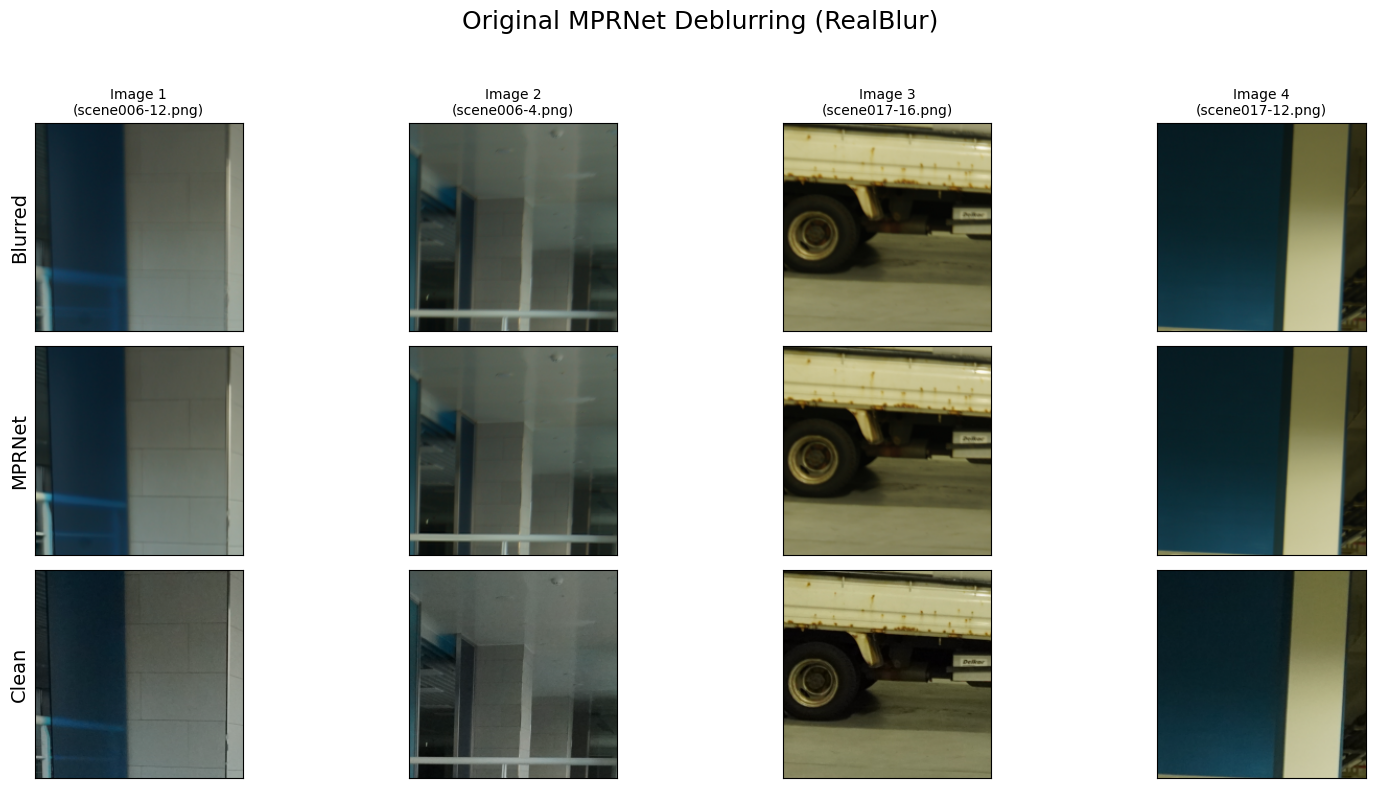

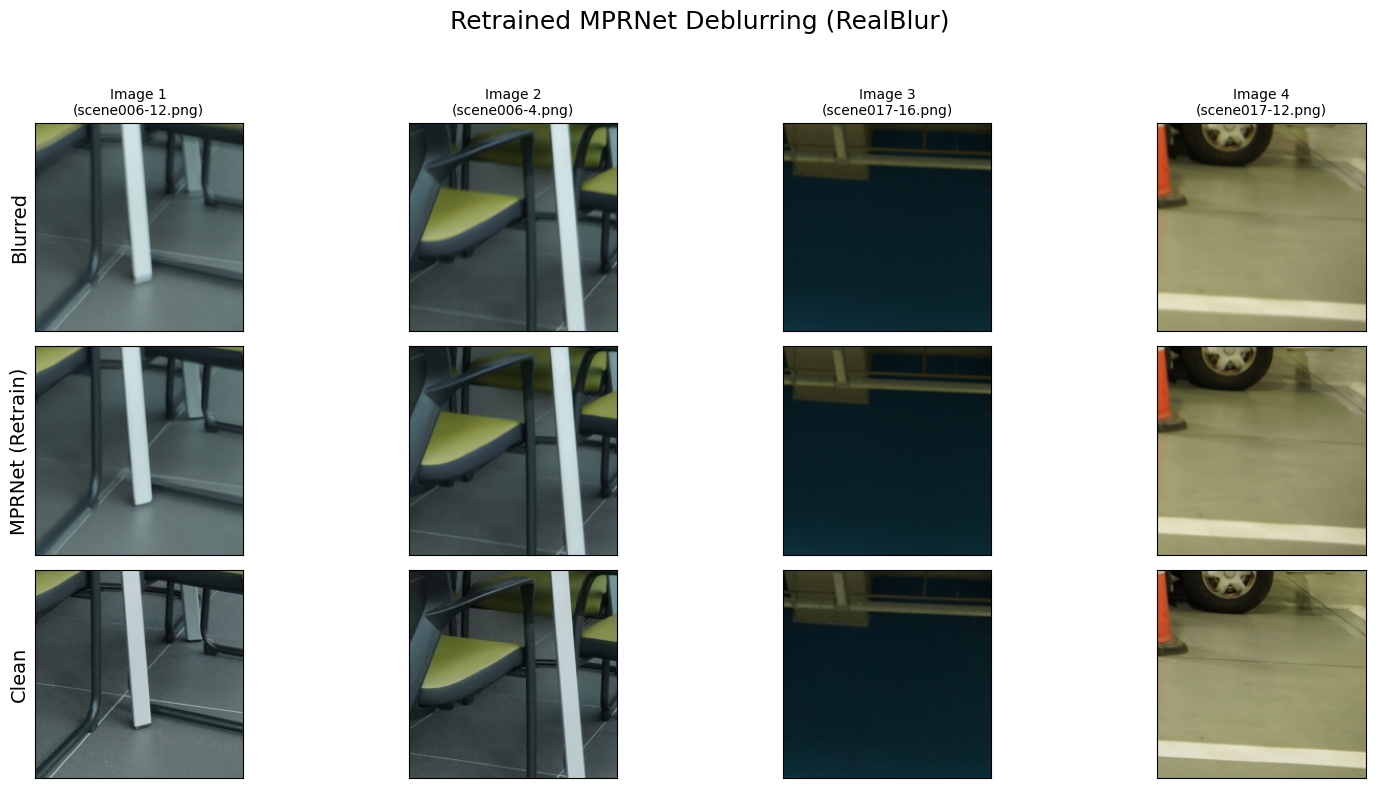

In [36]:
import os
import random
import re
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, img_as_float

# -----------------------------
# Paths
# -----------------------------
blur_dir        = "./Datasets/RealBlur/test/input"
gt_dir          = "./Datasets/RealBlur/test/target"
orig_res_dir    = "./results/without_retrain/RealBlur"
retrain_res_dir = "./results/retrain/RealBlur"

IMG_EXTS = (".png", ".jpg", ".jpeg", ".bmp")

# -----------------------------
# User controls
# -----------------------------
NUM_SCENES_TO_USE = 4      # how many different scenes to use at most
IMAGES_PER_SCENE  = 2      # how many images to pick from each scene

# -----------------------------
# Extract scene ID from filename
# e.g. "scene006-9.png" -> "scene006"
# -----------------------------
def get_scene_id(filename: str):
    # match "scene" + digits before "-" or "_"
    m = re.match(r"(scene\d+)[-_]", filename)
    return m.group(1) if m else None

# -----------------------------
# Collect valid files (exist in all dirs)
# -----------------------------
all_blur_files = [
    f for f in os.listdir(blur_dir)
    if f.lower().endswith(IMG_EXTS)
]

valid_files = []
for f in all_blur_files:
    if (os.path.exists(os.path.join(gt_dir, f)) and
        os.path.exists(os.path.join(orig_res_dir, f)) and
        os.path.exists(os.path.join(retrain_res_dir, f))):
        valid_files.append(f)

print("Total usable images:", len(valid_files))

# -----------------------------
# Group by sceneXXX
# -----------------------------
scene_dict = {}
for fname in valid_files:
    sid = get_scene_id(fname)
    if sid is None:
        continue
    scene_dict.setdefault(sid, []).append(fname)

print("Number of distinct scenes:", len(scene_dict))

# -----------------------------
# Select scenes and images
# -----------------------------
random.seed(0)

all_scene_ids = list(scene_dict.keys())
if not all_scene_ids:
    raise RuntimeError("No valid scenes found with matching blur/GT/original/retrain images.")

num_scenes_available = len(all_scene_ids)
num_scenes_to_select = min(NUM_SCENES_TO_USE, num_scenes_available)

scene_ids_selected = random.sample(all_scene_ids, num_scenes_to_select)

selected_files = []
for sid in scene_ids_selected:
    files_in_scene = scene_dict[sid]
    k = min(IMAGES_PER_SCENE, len(files_in_scene))
    # randomly pick k images from this scene
    chosen = random.sample(files_in_scene, k)
    selected_files.extend(chosen)

print("Selected scene IDs:", scene_ids_selected)
print("Selected files    :", selected_files)

# -----------------------------
# Image loading helper
# -----------------------------
def load_img(path):
    img = io.imread(path)
    if img.ndim == 2:
        img = np.stack([img, img, img], axis=-1)
    return img_as_float(img)

# -----------------------------
# Plot function (random 100x100 crop for each selected image)
# -----------------------------
def plot_compare_grid(selected_files, pred_root, middle_label, title, crop_size=100, seed=123):
    n = len(selected_files)
    fig, axes = plt.subplots(3, n, figsize=(4 * n, 8))
    axes = np.atleast_2d(axes)
    row_titles = ["Blurred", middle_label, "Clean"]

    rng = random.Random(seed)  # deterministic crops if you keep the seed fixed

    for col, fname in enumerate(selected_files):
        blur_img  = load_img(os.path.join(blur_dir, fname))
        pred_img  = load_img(os.path.join(pred_root, fname))
        clean_img = load_img(os.path.join(gt_dir,   fname))

        # Ensure 3-channel
        if blur_img.ndim == 2:
            blur_img = np.stack([blur_img]*3, axis=-1)
        if pred_img.ndim == 2:
            pred_img = np.stack([pred_img]*3, axis=-1)
        if clean_img.ndim == 2:
            clean_img = np.stack([clean_img]*3, axis=-1)

        H, W = blur_img.shape[0], blur_img.shape[1]
        cs = min(crop_size, H, W)  # avoid out-of-bound

        # Random crop coordinates (same for all three images in this column)
        y0 = 0 if H == cs else rng.randint(0, H - cs)
        x0 = 0 if W == cs else rng.randint(0, W - cs)

        blur_crop  = blur_img[y0:y0+cs, x0:x0+cs, :]
        pred_crop  = pred_img[y0:y0+cs, x0:x0+cs, :]
        clean_crop = clean_img[y0:y0+cs, x0:x0+cs, :]

        imgs = [blur_crop, pred_crop, clean_crop]

        for row in range(3):
            ax = axes[row, col]
            ax.imshow(imgs[row])
            ax.set_xticks([])
            ax.set_yticks([])

            # Left-side row labels
            if col == 0:
                ax.set_ylabel(row_titles[row], fontsize=14)

            # Column title
            if row == 0:
                ax.set_title(f"Image {col+1}\n({fname})", fontsize=10)

    plt.suptitle(title, fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# -----------------------------
# Plot: original and retrained
# -----------------------------
plot_compare_grid(
    selected_files=selected_files,
    pred_root=orig_res_dir,
    middle_label="MPRNet",
    title="Original MPRNet Deblurring (RealBlur)",
    crop_size=200,
    seed=123
)

plot_compare_grid(
    selected_files=selected_files,
    pred_root=retrain_res_dir,
    middle_label="MPRNet (Retrain)",
    title="Retrained MPRNet Deblurring (RealBlur)",
    crop_size=200,
    seed=456   # different seed -> different crop regions
)
